In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mapping from/to integers
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters to predict the next one

def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [79]:
# MLP revisited
n_embd = 10
n_hidden = 200

g =torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator = g)
W1 = torch.randn((block_size * n_embd, n_hidden),   generator = g) * (5/3) / ((block_size * n_embd)**0.5) #*0.2
# b1 = torch.randn(n_hidden,                          generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01 # to make initial logits more uniform
b2 = torch.randn(vocab_size,                        generator = g) * 0 # to make initial logits more uniform

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total no of parameters
for p in parameters:
    p.requires_grad = True

12297


tensor(-0.0009) tensor(0.9986)
tensor(0.0005) tensor(0.9753)


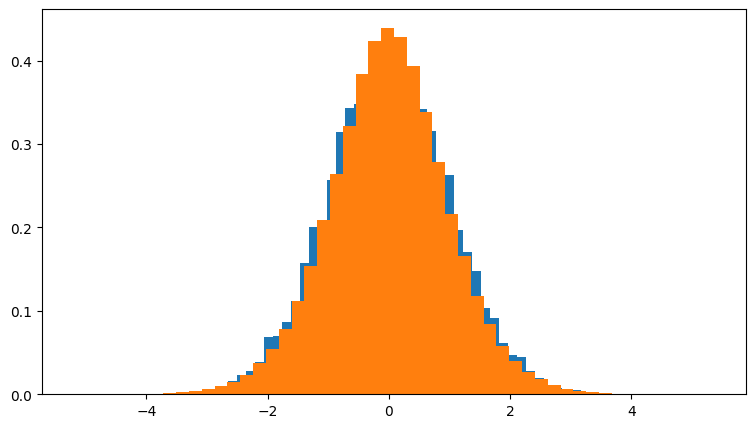

In [52]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(121)
plt.hist(y.view(-1).tolist(), 50, density=True);

Multiply the activation by a value to get the initial output value closer to the standard normal value of std = 1.0. For a tanh activation, the weights of the neurons has to be multiplied by (5/3)/sqrt(fan_in). For the current layer 1, the fan_in is (n_embd * block_size) which is (10 * 3) = 30. So the weights of the neurons in the current layer 1 has to be multiplied by (5/3)/sqrt(30) = 0.304.
This method of initialization is called Kaiming init

At least initially, we want the hpreact to be close to the standard normal distribution. This is because, during backpropogation, if the values of this layer are extremes, the gradients will not flow through those neurons and if they are too small, the tanh does not add anythign to the input. So, we want the hpreact to be close to the standard normal distribution.

To achieve this, we BatchNormalize.
Basically we subtract the mean from hpreact and divide them by the standard deviation. This will make the hpreact close to the standard normal distribution.

In [80]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] # embed the characters from current batch into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate for matrixmul
    hpreact = embcat @ W1 #+ b1 # hiddem layer pre activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


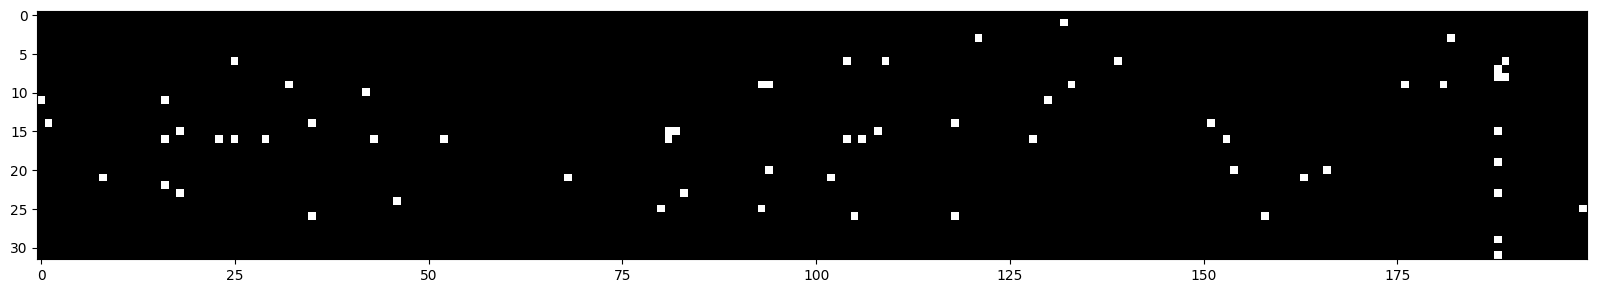

In [41]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

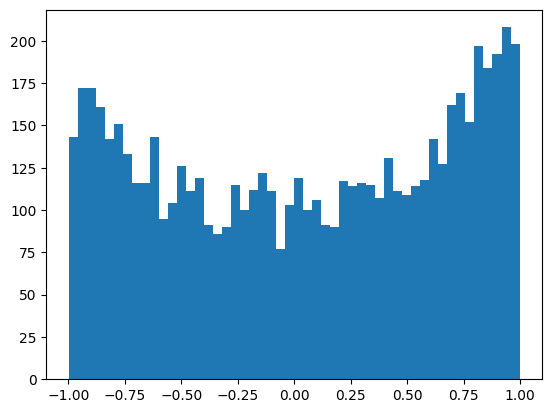

In [42]:
plt.hist(h.view(-1).tolist(), 50);

Backpropogation through tanh when that more values are 1 and -1 are bad. <br>
gradient at tanh => (1 - t**2) * out.grad. the local gradient becomes zero and effectively stops the flow of gradient through the tanh function <br>
Intuitively, 1 and -1 lies in the extremes or the flat regions of tanh function. So the gradient is almost zero and change in input has no effect on this

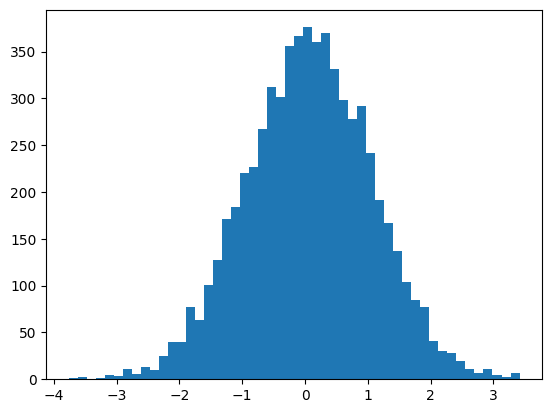

In [43]:
plt.hist(hpreact.view(-1).tolist(), 50);

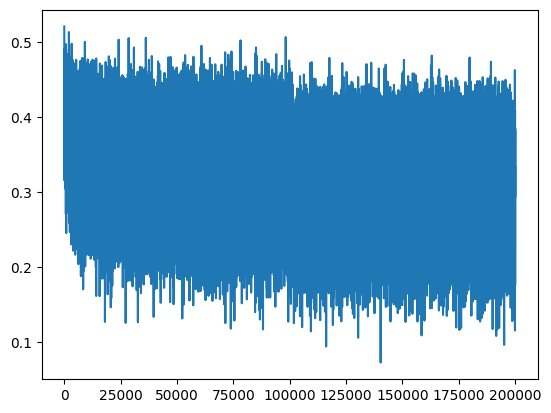

In [46]:
plt.plot(lossi)

To calibrate the batchnorm at the end of training. This is done because while predicting or sampling from the model, the model expects a batch and not a single input. Therefore we fix the whole mean and std of the entire training dataset and use it for the batchnorm layer.

The paper also suggest to calculate these while running in training and not after. This is done above

In [81]:
# Calibrate the batch norm at the end of training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [82]:
bnstd

tensor([[2.3929, 2.1364, 2.2663, 1.9944, 2.1860, 2.3736, 2.2576, 2.3451, 2.3578,
         2.1045, 2.4973, 2.2571, 2.1519, 2.2017, 2.0989, 2.7105, 2.4423, 1.8902,
         2.2073, 2.5144, 2.3232, 2.3402, 2.1268, 2.0214, 2.0374, 1.8407, 2.1634,
         2.6021, 2.2403, 2.3329, 1.7083, 1.9046, 2.0957, 1.8207, 2.0848, 1.9323,
         2.4885, 2.1671, 2.1170, 1.8611, 2.0108, 2.0911, 2.4064, 1.9754, 1.9694,
         2.4172, 2.1965, 2.5617, 2.1547, 2.4972, 2.0511, 1.8491, 2.0182, 1.7755,
         2.3971, 2.2096, 1.7725, 2.2930, 2.5639, 1.7747, 2.1165, 1.9382, 2.0266,
         2.2968, 2.1514, 2.3390, 2.1540, 2.4904, 2.0355, 2.1785, 2.0923, 1.9756,
         1.9921, 2.2562, 1.9101, 1.8626, 2.5723, 2.2043, 1.6819, 2.2513, 2.0126,
         1.8353, 2.0170, 2.2116, 2.5047, 2.3529, 2.1391, 2.3848, 2.5823, 2.6848,
         2.0914, 1.9556, 2.1100, 1.9680, 1.8659, 2.2201, 2.1905, 2.0695, 1.8927,
         2.3433, 2.0515, 2.1435, 2.2729, 2.0000, 1.9994, 2.2907, 1.8655, 2.2061,
         1.9252, 2.1527, 2.3

In [83]:
bnstd_running

tensor([[2.3689, 2.0998, 2.2499, 1.9599, 2.1515, 2.3429, 2.2431, 2.3104, 2.3309,
         2.0823, 2.4680, 2.2253, 2.1192, 2.1805, 2.0655, 2.6865, 2.4191, 1.8718,
         2.1882, 2.4989, 2.2903, 2.3143, 2.1068, 1.9938, 2.0172, 1.8189, 2.1352,
         2.5721, 2.2250, 2.3027, 1.6857, 1.8987, 2.0912, 1.8024, 2.0771, 1.9073,
         2.4760, 2.1356, 2.0873, 1.8440, 1.9877, 2.0603, 2.3704, 1.9412, 1.9464,
         2.4033, 2.1706, 2.5047, 2.1319, 2.4826, 2.0177, 1.8195, 1.9937, 1.7548,
         2.3758, 2.1857, 1.7500, 2.2775, 2.5494, 1.7520, 2.0970, 1.9272, 2.0154,
         2.2870, 2.1270, 2.3166, 2.1311, 2.4586, 2.0074, 2.1552, 2.0607, 1.9617,
         1.9790, 2.2358, 1.8885, 1.8480, 2.5581, 2.1731, 1.6619, 2.2316, 1.9924,
         1.8106, 1.9824, 2.1808, 2.4859, 2.3152, 2.1121, 2.3617, 2.5755, 2.6760,
         2.0648, 1.9299, 2.1034, 1.9445, 1.8592, 2.1894, 2.1640, 2.0496, 1.8632,
         2.3143, 2.0495, 2.1165, 2.2337, 1.9762, 1.9748, 2.2615, 1.8477, 2.1645,
         1.9084, 2.1207, 2.3

In [84]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
# split_loss('test')

train 2.06659197807312
val 2.1050572395324707


In [85]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        #forward pass
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0],-1)
        hpreact = embcat @ W1 #+ b1
        # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        #shift the context window
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
ryla.
reimastengraeg.
adelyn.
elin.
shi.
jen.
eden.
sana.
arleigh.
malaia.
noshubergahimie.
tri.
joselle.
jose.
casubelledi.
jamyleyeh.


In [ ]:
# SUMMARY ---------------

In [25]:
# Deeper Neural Net

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),      generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters
for p in parameters:
    p.requires_grad = True

47551


In [26]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i>1000:
        break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

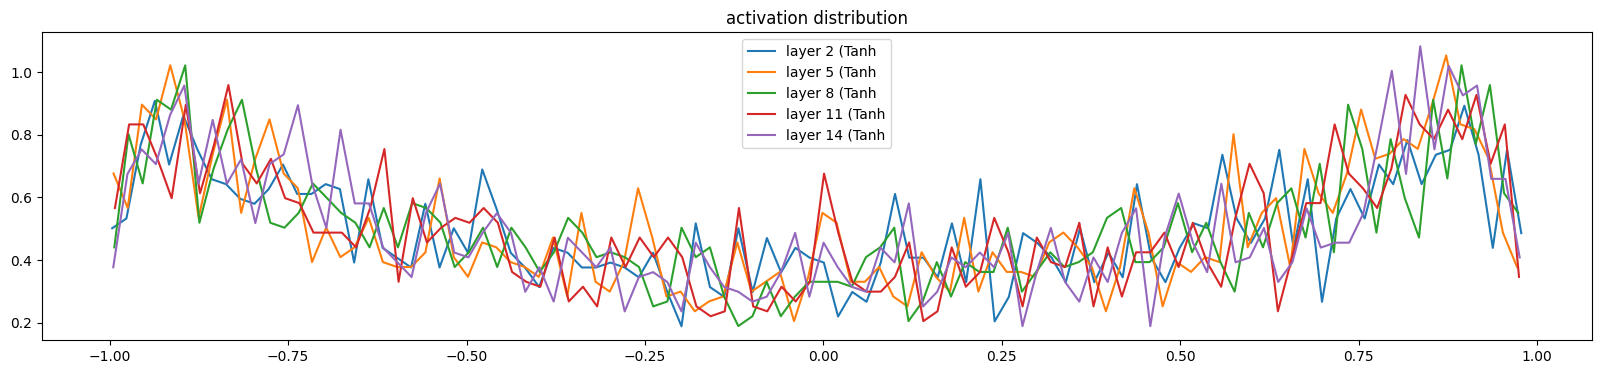

In [27]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.561980e-03
layer 5 (      Tanh): mean -0.000000, std 3.119525e-03
layer 8 (      Tanh): mean -0.000000, std 2.904406e-03
layer 11 (      Tanh): mean +0.000000, std 2.580224e-03
layer 14 (      Tanh): mean -0.000000, std 2.440871e-03


Text(0.5, 1.0, 'gradient distribution')

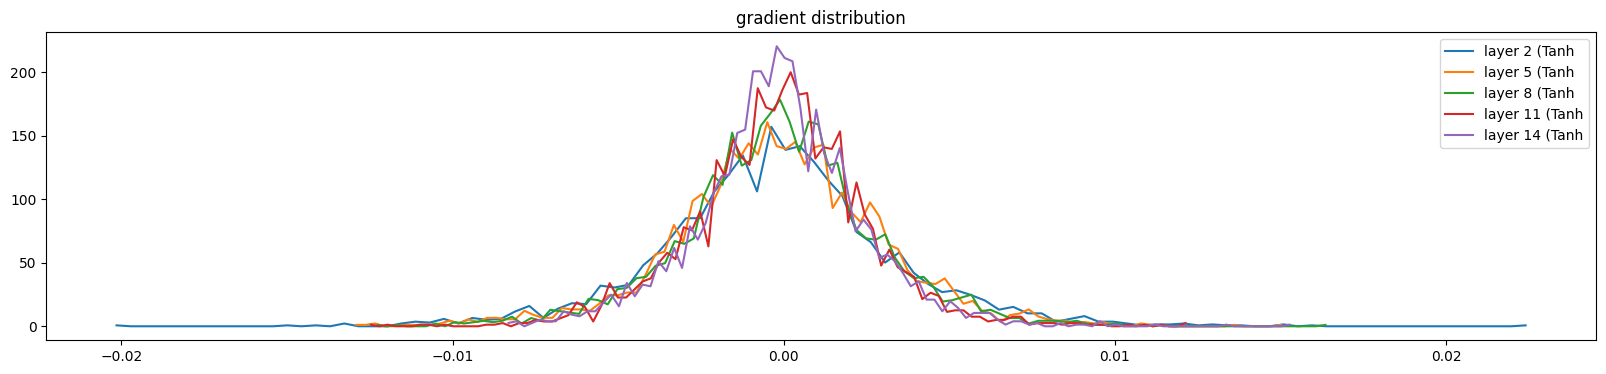

In [28]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.198651e-03 | grad:data ratio 8.190293e-03
weight  (30, 100) | mean -0.000195 | std 7.650394e-03 | grad:data ratio 2.447697e-02
weight (100, 100) | mean -0.000097 | std 6.207571e-03 | grad:data ratio 3.712875e-02
weight (100, 100) | mean +0.000015 | std 5.561919e-03 | grad:data ratio 3.297628e-02
weight (100, 100) | mean +0.000008 | std 5.220601e-03 | grad:data ratio 3.110151e-02
weight (100, 100) | mean +0.000029 | std 4.829161e-03 | grad:data ratio 2.876369e-02
weight  (100, 27) | mean -0.000014 | std 9.281213e-03 | grad:data ratio 5.568816e-02


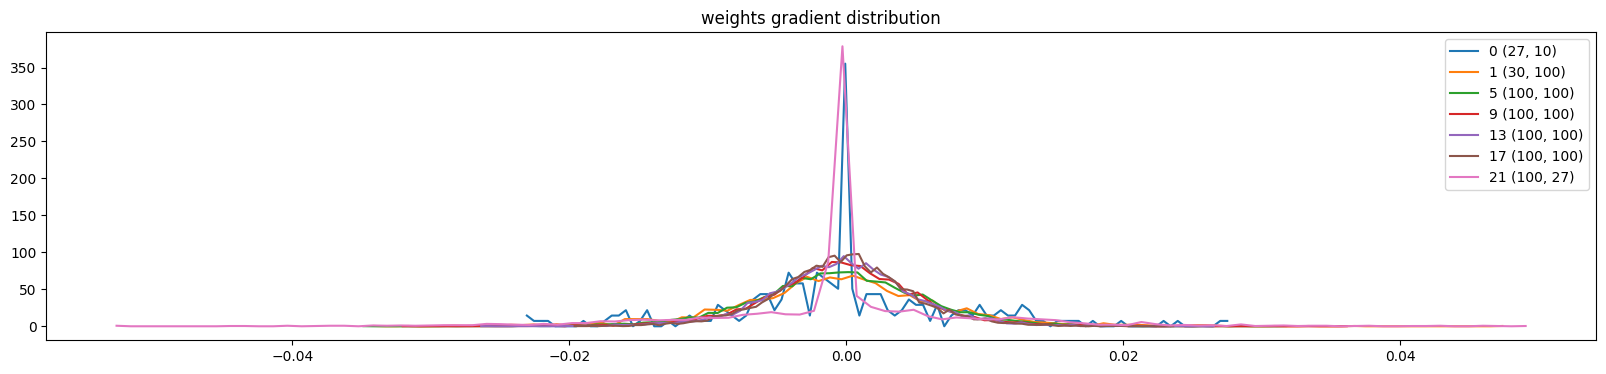

In [29]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

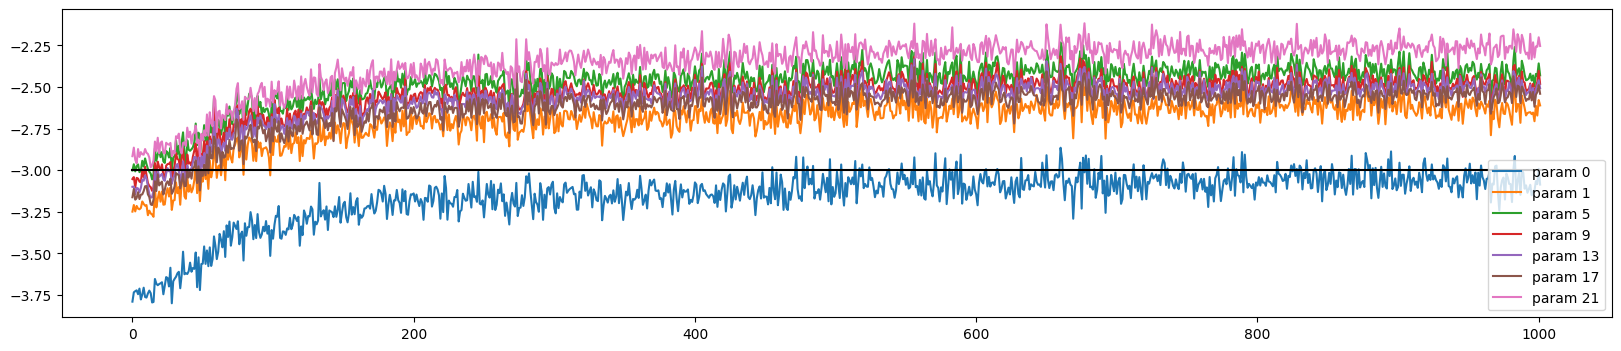

In [30]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);